# PRIOR AND POSTERIOR PREDICTIVE CHECKS

## Load libraries

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import xarray as xr

from scipy.special import expit as logistic


print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.7.1


In [2]:
az.style.use("arviz-darkgrid")

## Load data

In [20]:
seed = 58
rng = np.random.default_rng(seed)

In [21]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [22]:
N = 100

trueA, trueB, predictor = 0.5, 3.0, rng.normal(loc = 2, scale = 6, size = N)
trueMu = trueA + trueB * predictor
trueSd = 2.0

outcome = rng.normal(loc = trueMu, scale = trueSd, size = N)

f"{predictor.mean():.2f}, {predictor.std():.2f}, {outcome.mean():.2f}, {outcome.std():.2f}"

'1.59, 5.69, 4.97, 17.54'

### Standardize the data

In [23]:
predScaled = standardize(predictor)
outScaled = standardize(outcome)

f"{predScaled.mean():.2f}, {predScaled.std():.2f}, {outScaled.mean():.2f}, {outScaled.std():.2f}"

'0.00, 1.00, -0.00, 1.00'

## Flat priors

### Model specification

In [24]:
with pm.Model() as model_1:
    a = pm.Normal('a', 0.0, 10.0)
    b = pm.Normal('b', 0.0, 10.0)
    
    mu = a + b * predScaled
    sigma = pm.Exponential('sigma', 1.0)
    
    pm.Normal('obs', mu = mu, sigma = sigma, observed = outScaled)

### Sampling priors 

In [25]:
with model_1:
    idata = pm.sample_prior_predictive(samples = 50, random_seed = rng)

Sampling: [a, b, obs, sigma]


### Plot priors

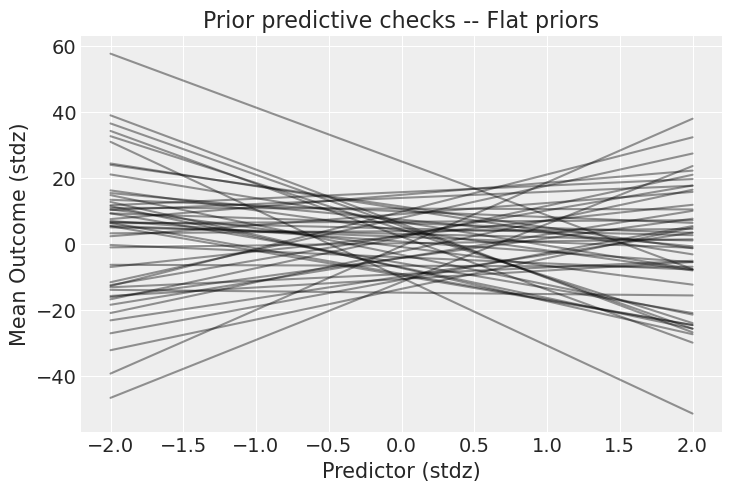

In [26]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

## Weakly regularizing priors

### Model specificaiton

In [33]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 0.5)
    b = pm.Normal("b", 0.0, 1.0)

    mu = a + b * predScaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu = mu, sigma = sigma, observed = outScaled)

### Sampling priors

In [34]:
with model_1:
    idata = pm.sample_prior_predictive(samples = 50, random_seed = rng)

Sampling: [a, b, obs, sigma]


### Plot priors

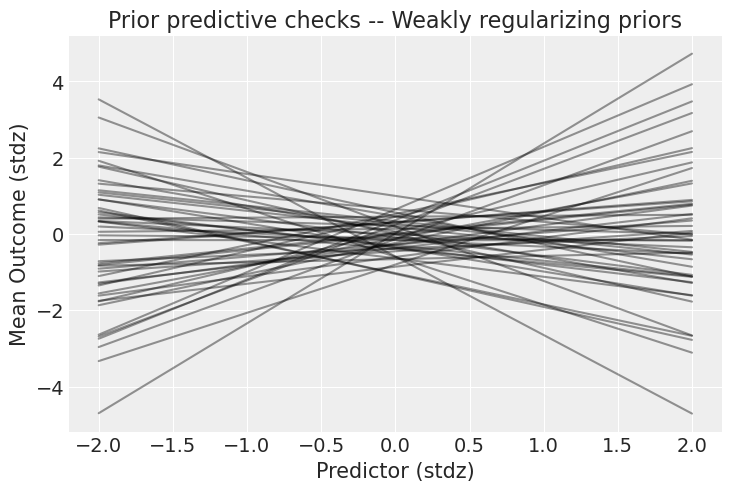

In [35]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

## Run model

In [36]:
with model_1:
    idata.extend(pm.sample(1000, tune = 2000, random_seed = rng))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 70 seconds.


## Check chains

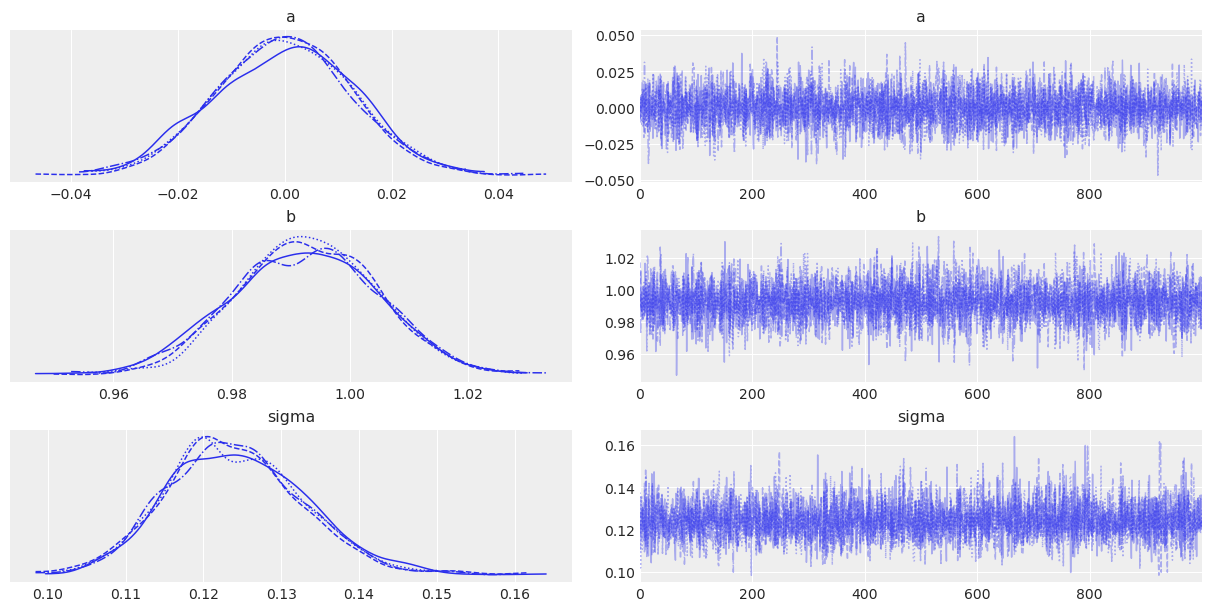

In [38]:
az.plot_trace(idata);

## Posterior predective sampling

In [39]:
with model_1:
    pm.sample_posterior_predictive(idata, extend_inferencedata = True, random_seed = rng)

Sampling: [obs]


In [40]:
idata.posterior_predictive

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1000, obs_dim_2: 100)
Coordinates:
  * chain      (chain) int32 0 1 2 3
  * draw       (draw) int32 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * obs_dim_2  (obs_dim_2) int32 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    obs        (chain, draw, obs_dim_2) float64 -0.5997 0.312 ... -0.3247 0.4695
Attributes:
    created_at:                 2023-08-07T14:31:16.689317
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.7.1

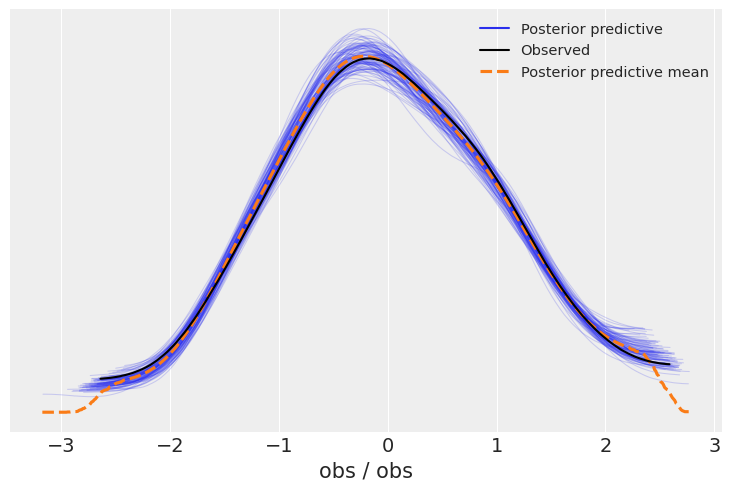

In [42]:
az.plot_ppc(idata, num_pp_samples=100);

In [43]:
post = idata.posterior
post

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    a        (chain, draw) float64 0.003245 -0.006658 ... -0.01237 0.008763
    b        (chain, draw) float64 0.9938 0.9887 0.9985 ... 0.9779 0.9992 0.9884
    sigma    (chain, draw) float64 0.1105 0.1355 0.1242 ... 0.1182 0.1222 0.1244
Attributes:
    created_at:                 2023-08-07T14:27:46.740999
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.7.1
    sampling_time:              69.58435201644897
    tuning_steps:               2000

In [45]:
muPP = post['a'] + post['b'] * xr.DataArray(predScaled, dims = ['obs_id'])

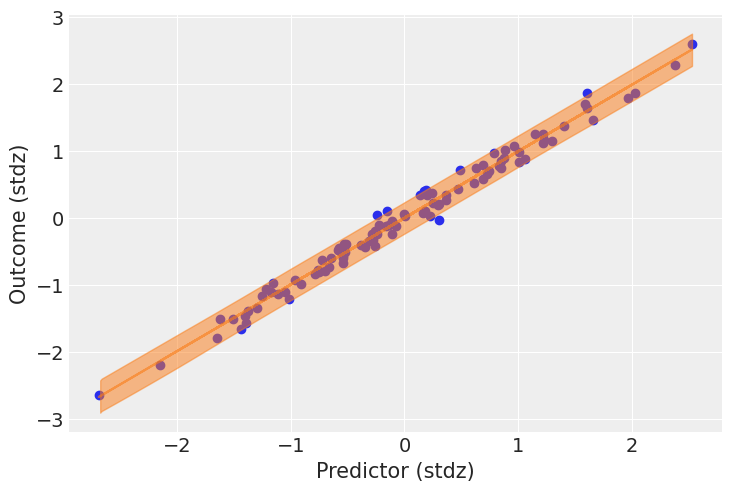

In [50]:
_, ax = plt.subplots()

ax.plot(
    predScaled, muPP.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(predScaled, idata.observed_data["obs"])
az.plot_hdi(predScaled, idata.posterior_predictive["obs"])

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)");

## Prediction

### Data

In [51]:
N = 400
trueInt = 0.2
trueSlope = 1.0
predictors = rng.normal(size = N)
trueP = logistic(trueInt + trueSlope * predictors)

outcomes = rng.binomial(1, trueP)
outcomes[:10]

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 0], dtype=int64)

### Model

In [52]:
with pm.Model() as model_2:
    betas = pm.Normal('betas', mu = 0.0, sigma = np.array([0.5, 1.0]), shape = 2)
    
    # Set predictors as shared variable to change them for PPCs:
    pred = pm.MutableData('pred', predictors, dims = 'obs_id')
    p = pm.Deterministic('p', pm.math.invlogit(betas[0] + betas[1] * pred), dims = 'obs_id')
    
    # Likelyhood
    outcome = pm.Bernoulli('outcome', p = p, observed = outcomes, dims = 'obs_id')

### Run chains

In [53]:
with model_2:
    idata_2 = pm.sample(1000, tune = 2000, return_inferencedata = True, random_seed = rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 76 seconds.


### Sumarize results

In [54]:
az.summary(idata_2, var_names = ['betas'], round_to = 2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.23,0.11,0.03,0.44,0.0,0.0,3211.49,3013.30,1.0
betas[1],1.03,0.13,0.78,1.29,0.0,0.0,3673.85,2720.49,1.0


### Simulate out-of-sample data

In [55]:
predictors_out_of_sample = rng.normal(size = 50)

In [57]:
outcomes_out_of_sample = rng.binomial(
    1, logistic(trueInt + trueSlope * predictors_out_of_sample)
)

In [59]:
with model_2:
    # update valies of predictors
    pm.set_data({'pred': predictors_out_of_sample})
    
    # use the updated values and predict outcomes and probabilities:
    idata_2 = pm.sample_posterior_predictive(
        idata_2,
        var_names = ['p'],
        return_inferencedata = True,
        predictions = True,
        extend_inferencedata = True,
        random_seed = rng,
    
    )

Sampling: []


In [60]:
idata_2

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

### Analyse predicted data

In [64]:
preds_out_of_sample = idata_2.predictions_constant_data.sortby("pred")["pred"]

preds_out_of_sample

<xarray.DataArray 'pred' (obs_id: 50)>
array([-2.43737566, -2.02234496, -1.59136919, -1.43597111, -1.33175911,
       -1.28745218, -1.25687529, -1.20562866, -1.06029397, -0.80642124,
       -0.79822712, -0.79425379, -0.76535716, -0.70089948, -0.67969629,
       -0.44997777, -0.42621178, -0.33791551, -0.29521294, -0.21451192,
       -0.16178002, -0.14702064, -0.10646806, -0.0482979 ,  0.03558471,
        0.04612684,  0.05691134,  0.06561494,  0.09280583,  0.1014928 ,
        0.15827783,  0.22494532,  0.27588396,  0.3244377 ,  0.4085491 ,
        0.41015748,  0.56180771,  0.5668241 ,  0.58341966,  0.70890617,
        0.84697803,  0.91540495,  1.01338466,  1.01372423,  1.05227109,
        1.14029925,  1.3041003 ,  1.30641037,  1.38606747,  1.86217755])
Coordinates:
  * obs_id   (obs_id) int32 23 16 1 46 13 26 45 15 21 ... 28 38 19 39 5 20 37 17

In [65]:
model_preds = idata_2.predictions.sortby(preds_out_of_sample)

model_preds

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, obs_id: 50)
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * obs_id   (obs_id) int32 23 16 1 46 13 26 45 15 21 ... 28 38 19 39 5 20 37 17
Data variables:
    p        (chain, draw, obs_id) float64 0.116 0.164 0.2295 ... 0.8553 0.9094
Attributes:
    created_at:                 2023-08-07T17:01:30.786034
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.7.1

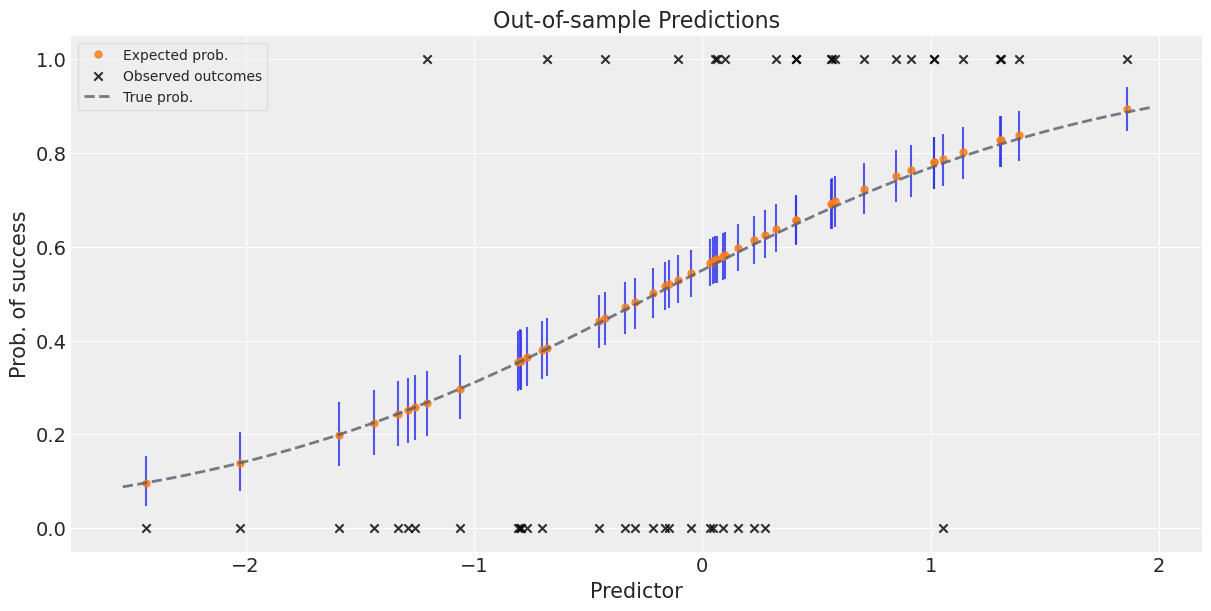

In [67]:
_, ax = plt.subplots(figsize=(12, 6))

# uncertainty about the estimates:
ax.vlines(
    preds_out_of_sample,
    *az.hdi(model_preds)["p"].transpose("hdi", ...),
    alpha=0.8,
)

# expected probability of success:
ax.plot(
    preds_out_of_sample,
    model_preds["p"].mean(("chain", "draw")),
    "o",
    ms=5,
    color="C1",
    alpha=0.8,
    label="Expected prob.",
)

# actual outcomes:
ax.scatter(
    x=predictors_out_of_sample,
    y=outcomes_out_of_sample,
    marker="x",
    color="k",
    alpha=0.8,
    label="Observed outcomes",
)

# true probabilities:
x = np.linspace(predictors_out_of_sample.min() - 0.1, predictors_out_of_sample.max() + 0.1)
ax.plot(
    x,
    logistic(trueInt + trueSlope * x),
    lw=2,
    ls="--",
    color="#565C6C",
    alpha=0.8,
    label="True prob.",
)

ax.set_xlabel("Predictor")
ax.set_ylabel("Prob. of success")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);